# Second report of lyrics dataset

After preprocessing and analyzing our dataset in the first report, we will now create a model. Our model will predict the genre and interpreter based on lyrics.

First, we will enhance preprocessing with additional transformations and add language prediction as a useful feature. Then we will try a few different models and find out which one performs the best. Then we will see the performance of the model.

1. [Preprocessing: featurization](#preprocessing-featurization)
2. [Model creation](#model-creation)
3. [Model results](#model-results)
4. [Summary](#summary)

This time, preprocessing and modelling have been moved to separate notebooks, so you can see them if you are interested in the code.

## 1. Preprocessing: featurization

We need to prepare our data for modelling. We will create 2 models: genre prediction and interpreter prediction.

First, we will prepare the data as in the first dataset - we will drop songs with no lyrics, songs without song name or release year or suspicious values of it. We will also try to merge interpreters that seem to just have the same name written differently, just like before. We will also create word count, unique word count and average word lenth as in the first report. TF-IDF features will be added later in modelling stage.

Since we are just interested in some simple model and we have a very large dataset, we will create a universal dataset for both models.

Genres contain 'Not Available' category that will not be very consistent and useful so we will drop all rows with this category.

The main problem for interpreter recognition will be that there are too many of them. The best solution is to keep only those with the most of songs. So I decided to only keep those that have more than 200 songs (but I also created some models with the threshold at 400). We could also keep interpreters with not many songs in "other" category, but there would be many of them and it probably would not be very useful. Since we have a large dataset, we can afford to make it smaller.

Last, we will use a language model to identify the language of each row. Since there is a lot of slang in individual songs, it can make many mistakes and if we were to productionalize the model, it would be useful to limit the possible languages. But since we are just creating something simple we can keep it as is and count with the fact that wrong language recognition can also be useful since it still says something about the style of the song.

You can see the preview of the resulting dataset below.

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
import mlflow
import seaborn as sns

df = pd.read_csv("preprocessed_filtered.csv")
df

,song_name,year,interpreter,genre,lyrics,word_count,unique_word_count,average_word_length,language
0,Without You,1968,Fleetwood Mac,Rock,I'm crazy for my baby But my baby she don't lo...,107,27,3.542056,en
1,The Width Of A Circle,1970,David Cook,Rock,In the corner of the morning in the past I wou...,320,187,3.900000,en
2,All The Madmen,1970,David Cook,Rock,Day after day They send my friends away To man...,323,125,3.835913,en
3,Good Vibrations,1970,Beach Boys,Rock,"I, I love the colorful clothes she wears And t...",223,77,4.488789,en
4,Sloop John B,1970,Beach Boys,Rock,We come on the sloop john be My grandfather an...,270,93,3.362963,en
...,...,...,...,...,...,...,...,...,...
25340,I Wanna Be Around Friday Night,2016,Beach Boys,Rock,I wanna be around to pick up the pieces When s...,32,26,4.375000,en
25341,Prelude Quadrophonic Mix,2016,Chicago,Rock,Lying here as the morning light shines in Can'...,34,31,4.088235,en
25342,Believe Me Now Album Version,2016,Electric Light Orchestra,Rock,"Can you hear me? Ahhhhhh, Something, something...",22,18,4.727273,en
25343,Dreamin Home Quadrophonic Mix,2016,Chicago,Rock,"Dream, dream, dream Dreams in the night Take m...",22,21,4.227273,en


The dataset has about 25 thousand rows, so there is still enough data for a model. You can also see below how many interpreters we have in the dataset. There are 56 of them so that seems like a number that could be feasible for a model.

In [73]:
interpreter_counts = df['interpreter'].value_counts()

print(f"Number of unique interpreters: {len(interpreter_counts)}")

Number of unique interpreters: 56


In the following image, you can see the distribution of the recognized languages. Since there is much more English songs than other, the scale is logarithmic. The least represented languages might sometimes be mistakes, however the most represented ones seem to correspond to our previous observation.

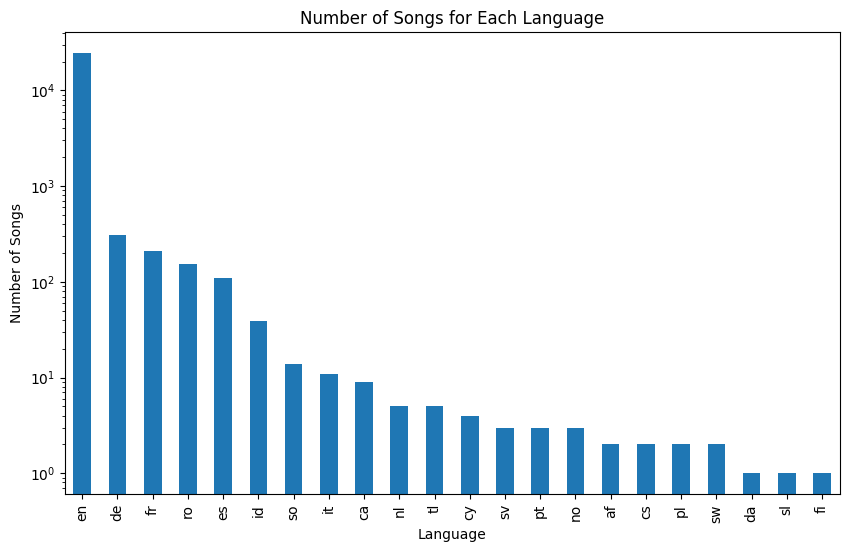

In [74]:
language_counts = df['language'].value_counts()

plt.figure(figsize=(10, 6))
language_counts.plot(kind='bar', logy=True)
plt.title('Number of Songs for Each Language')
plt.xlabel('Language')
plt.ylabel('Number of Songs')
plt.show()

Genre representation has also changed with our filters as you can see in the following plot. There is more rock songs than any other as well but the scale was kept linear this time.

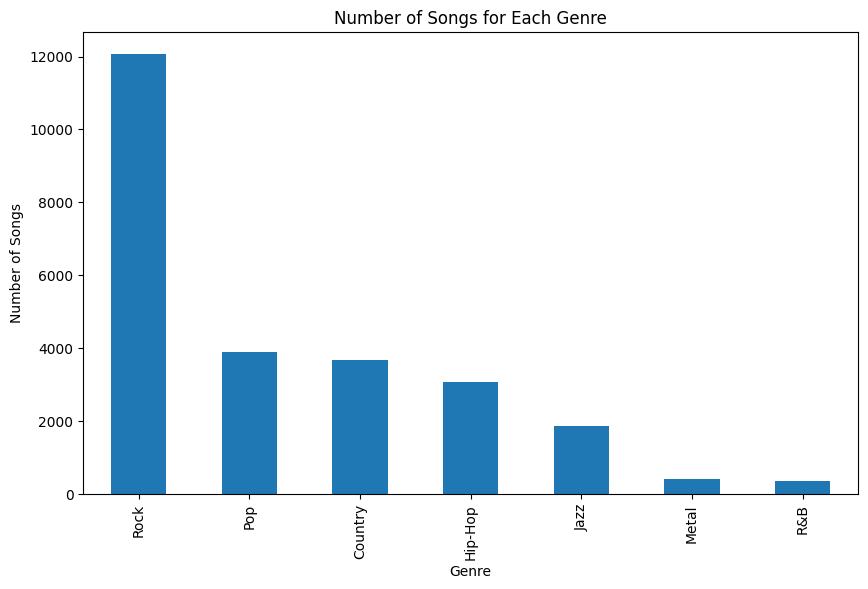

In [75]:
genre_counts = df['genre'].value_counts()

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', logy=False)
plt.title('Number of Songs for Each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.show()

##  2. Model creation

Based on the information from the Data Science classes, I have decided to try logistic regression as the base model and then also try Multinomial Naive Bayes classificator. Based on information from Machine Learning for Greenhorns, I also wanted to try SVC and a simple MLP. However, I only trained a smaller model on them because it was slower and not much better.

I have tried training with various thresholds for the minimal number of songs of an interpreter. Although genre recognition gets better with more interpreters, the models for interpreter get worse and the models get slower. I have decided to show results of the threshold at 300 (as in the statistics above) and at 400 (with 27 interpreters). I have also trained models on other thresholds, but the difference was proportional to the difference between 300 and 400. I have also tried GridSearchCV, but it did not affect the results much so in the end I decided to just keep the defaults.

I have used MLflow to track my models. You can see the summary of the latest, most representable results below (for Naive Bayes, SVC and Logistic Regression). The first results are for the threshold at 300.

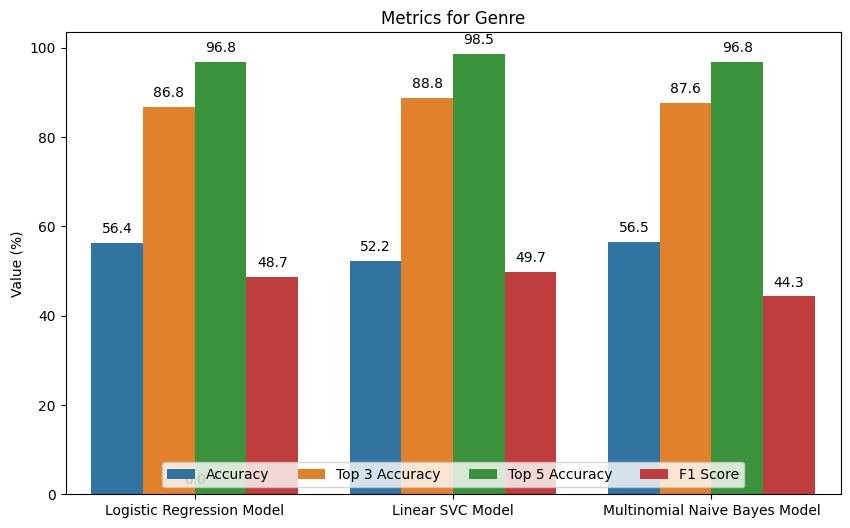

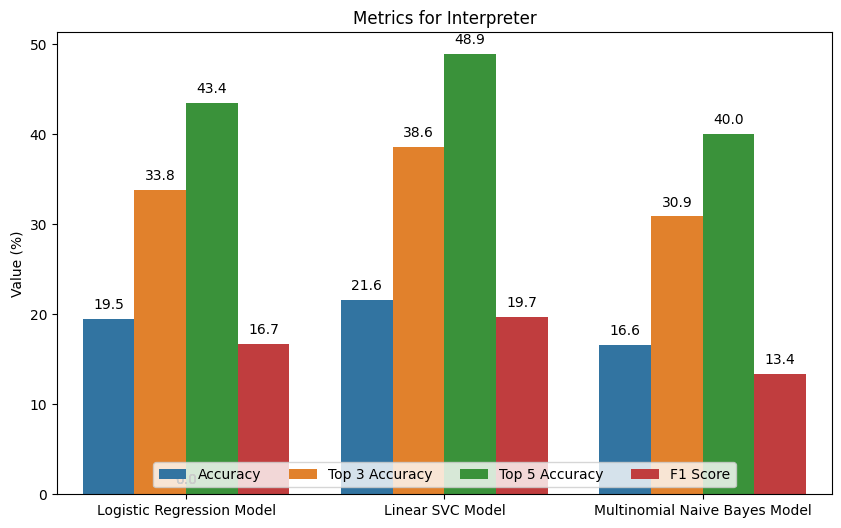

In [136]:
client = MlflowClient()
mlflow.set_tracking_uri('http://localhost:5000/')
runs = client.search_runs(experiment_ids="0")
data = []
for run in runs:
    metrics = run.data.metrics
    params = run.data.params
    tags = run.data.tags
    data.append({**metrics, **params, **tags})

df = pd.DataFrame(data)

df['accuracy'] = df['accuracy'] * 100
df['top3_accuracy'] = df['top3_accuracy'] * 100
df['top5_accuracy'] = df['top5_accuracy'] * 100
df['f1'] = df['f1'] * 100

df_mlflow = df.rename(columns={
    'mlflow.runName': 'Run Name',
    'accuracy': 'Accuracy',
    'top3_accuracy': 'Top 3 Accuracy',
    'top5_accuracy': 'Top 5 Accuracy',
    'f1': 'F1 Score'
})

df = df_mlflow[['Run Name', 'Accuracy', 'Top 3 Accuracy', 'Top 5 Accuracy', 'F1 Score', 'target']][:6]

df_genre = df[df['target'] == 'genre'].drop(['target'], axis=1)
df_interpreter = df[df['target'] == 'interpreter'].drop(['target'], axis=1)

for i, (df_pred, target) in enumerate(zip([df_genre, df_interpreter], ['Genre', 'Interpreter'])):
    df_melt = df_pred.melt(id_vars='Run Name', var_name='Metric', value_name='Value')

    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x='Run Name', y='Value', hue='Metric', data=df_melt)
    plt.title(f'Metrics for {target}')
    plt.ylabel('Value (%)')  
    labels = [label.replace(f'{target} ', '') for label in df_melt['Run Name'].unique()]
    plt.xticks(range(len(labels)), labels, rotation=0)
    plt.xlabel('')

    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')
        
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.0), ncol=4)

We can see that the models for genre have the best accuracy for Naive Bayes at 56.5 % and the models for interpreter have the best accuracy for SVC at 21.6 %. However for in accuracy for the top3/5, SVC is always the best.

The following results are for the threshold at 400.

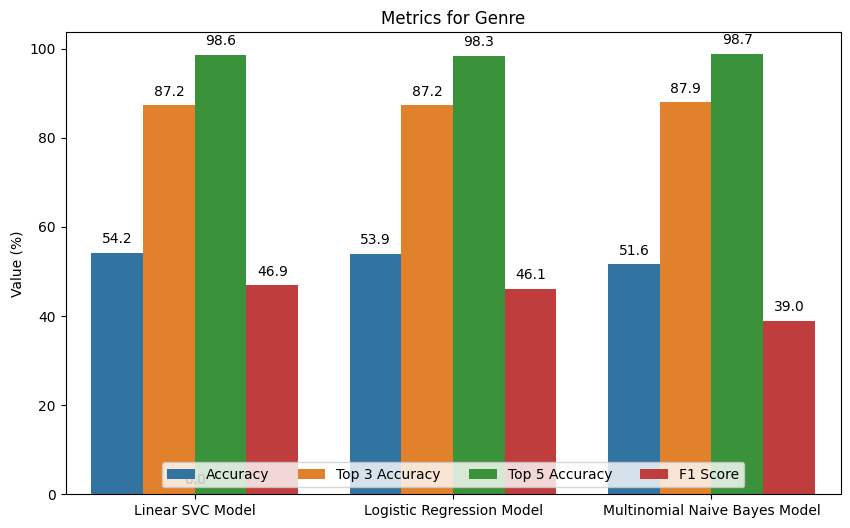

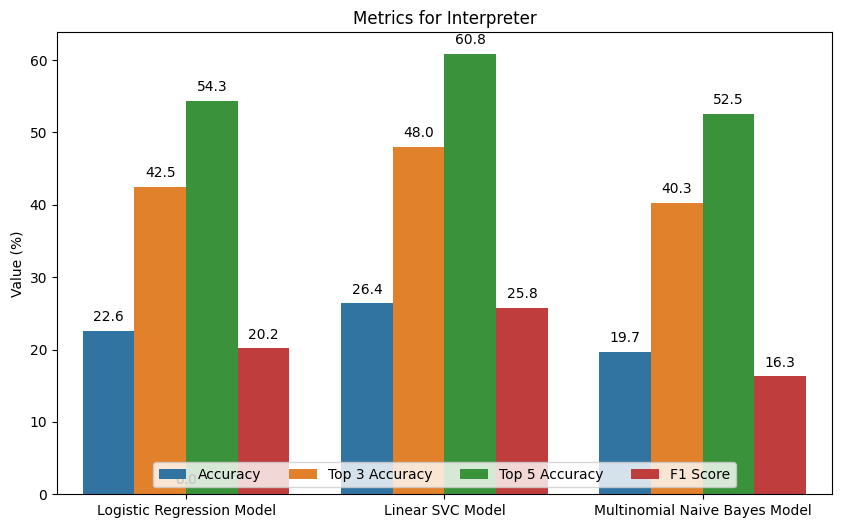

In [135]:
df = df_mlflow[['Run Name', 'Accuracy', 'Top 3 Accuracy', 'Top 5 Accuracy', 'F1 Score', 'target']][6:]

df_genre = df[df['target'] == 'genre'].drop(['target'], axis=1)
df_interpreter = df[df['target'] == 'interpreter'].drop(['target'], axis=1)

for df_pred, target in zip([df_genre, df_interpreter], ['Genre', 'Interpreter']):
    df_melt = df_pred.melt(id_vars='Run Name', var_name='Metric', value_name='Value')

    plt.figure(figsize=(10, 6))
    barplot=sns.barplot(x='Run Name', y='Value', hue='Metric', data=df_melt)
    plt.title(f'Metrics for {target}')
    plt.ylabel('Value (%)')  
    labels = [label.replace(f'{target} ', '') for label in df_melt['Run Name'].unique()]
    plt.xticks(range(len(labels)), labels, rotation=0)
    plt.xlabel('')

    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')


    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.0), ncol=4)
    plt.show()

We can see that the models for genre have the best accuracy for SVC at 54.2 % and the models for interpreter have also the best accuracy for SVC at 26.4 %. For the top3/5, SVC is again the best, just Naive Bayes is a bit better for the genre model. However its f1 score is very bad in this case.

The accuracies of individual models are not very high. But that is rather because of the large number of possible targets. That's why we also have a top3 and top5 accuracy metric which measures how often the correct class is in the 3 or 5 most probable ones. Note that top5 mostly makes sense for interpreter which has hundreds of categories since there are just 5-7 categories in genre (5 for the smaller dataset, 7 for the larger one). But considering we have tens of interpreters, identifying the correct one with 20 % probability and the interpreter being in top5 having even a 60 % probability is not a bad result. We can confidently say that genre and interpreter can be predicted - however usable results would probably require more preprocessing and model tuning or predicting just on a smaller number of interpreters.

Since the results are getting better for interpreter when I classify less interpreters and worse for genre, it would definitely be better to have a separate dataset for each of these models.

## 3. Model results

Although the model did not have the best accuracy in the larger dataset, since SVC performed the best overall and had the best F1 score, we will now see the details of the results of the SVC classifier with the threshold at 300.

Below you can see some predictions the model for genre on the test set along with the correct target. I have chosen genre for illustration since we would probably need to study more samples if we wanted to understand the results of the interpreter model.

In [78]:
logged_model = 'runs:/6bf6f03c57464cf18150c261eee08555/Genre Linear SVC_model'
loaded_model = mlflow.pyfunc.load_model(logged_model)
test_df = pd.read_csv('test_data_genre.csv')
predictions = loaded_model.predict(test_df.drop(['genre'], axis=1))
df_pred = pd.concat([test_df, pd.DataFrame(predictions, columns=['genre_predictions'])], axis=1)

In [79]:
pd.set_option('display.max_columns', 10)

df_pred

,year,word_count,unique_word_count,average_word_length,alone,...,language_sv,language_sw,language_tl,genre,genre_predictions
0,2010,0.041409,0.078448,0.200495,0.000000,...,False,False,False,Rock,Rock
1,2006,0.032756,0.049138,0.218807,0.000000,...,False,False,False,Rock,Rock
2,2006,0.029975,0.073276,0.194510,0.000000,...,False,False,False,Pop,Country
3,1994,0.055624,0.106034,0.179315,0.169981,...,False,False,False,Rock,Rock
4,2006,0.103523,0.139655,0.165480,0.000000,...,False,False,False,Country,Rock
...,...,...,...,...,...,...,...,...,...,...,...
5063,2006,0.070766,0.088793,0.143312,0.000000,...,False,False,False,Rock,Rock
5064,2016,0.072002,0.114655,0.158799,0.000000,...,False,False,False,Rock,Rock
5065,2006,0.068912,0.093103,0.237344,0.000000,...,False,False,False,Rock,Country
5066,2006,0.036774,0.033621,0.159874,0.000000,...,False,False,False,Rock,Rock


We can see  that this model is using the Country category a lot and it is making many mistakes. However, its accuracy was not the best. The correct genre will probably be at least among the best 3.

Next, you can see the percentage of samples correctly classified for each genre.

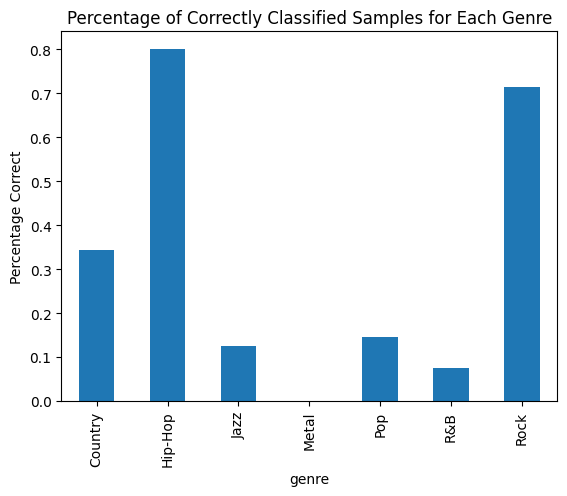

In [80]:
df_pred['IsCorrect'] = df_pred['genre_predictions'] == df_pred['genre']

correct_percentages = df_pred.groupby('genre')['IsCorrect'].mean()

correct_percentages.plot(kind='bar')
plt.ylabel('Percentage Correct')
plt.title('Percentage of Correctly Classified Samples for Each Genre')
plt.show()

This plot is rather bad news - our model only learned to recognize certain genres and it mostly guesses Rock or Hip-Hop, sometimes Country - so we have kind of a Rock/Hip-Hop recognizer. However that's no big surprise. For those results to be better, we would need to have a much larger representation for the other genres. We would definitely need to work on that in our further work if we wanted this model to be good.

You can see the results of the Naive Bayes classifier below. It is much better for Rock (which is the most frequent, so it gives the model high accuracy), but worse in all other genres.

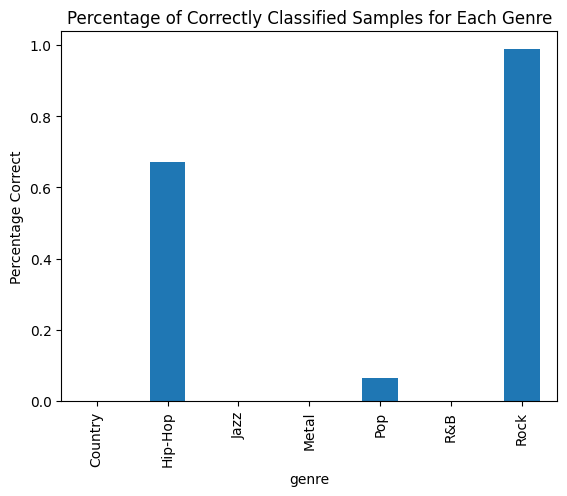

In [81]:
logged_model = 'runs:/b42ffa5f3dae495b815380ba0c2bd1fa/Genre Multinomial Naive Bayes_model'
loaded_model = mlflow.pyfunc.load_model(logged_model)
test_df = pd.read_csv('test_data_genre.csv')
predictions = loaded_model.predict(test_df.drop(['genre'], axis=1))
df_pred = pd.concat([test_df, pd.DataFrame(predictions, columns=['genre_predictions'])], axis=1)
df_pred['IsCorrect'] = df_pred['genre_predictions'] == df_pred['genre']

correct_percentages = df_pred.groupby('genre')['IsCorrect'].mean()

correct_percentages.plot(kind='bar')
plt.ylabel('Percentage Correct')
plt.title('Percentage of Correctly Classified Samples for Each Genre')
plt.show()

## Summary

After preprocessing analyzing the data in the first report, we have addded some further preprocessing and featurization. Then we tried to train several models including logistic regression, Naive Bayes and SVC.

We have found out that all our models can predict genre, even though it is not very good at it. The predictions could be made better with some further model tuning and dataset preparation.

Predicting the interpreter when there are hundreds is a complex task, so our models were not able to achieve much more than 20% accuracy. But considering that the correct interpreter was among the top 5 about 60% of the time, we can still consider such a model to be effective.

Acknowledgments: In the process of conducting the data analysis and building the models for this report, I utilized GitHub Copilot, an AI programming assistant powered by OpenAI's GPT-4 model. This tool provided assistance with code generation, debugging, and answering various programming-related queries. And with writing this acknowledgement. However, the rest of text is fully my work.